In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def chroma_subsample(ycbcr_image, subsample_factor=(2, 2)):
    Y, Cb, Cr = cv2.split(ycbcr_image)
    
    Cb_subsampled = Cb[::subsample_factor[1], ::subsample_factor[0]]
    Cr_subsampled = Cr[::subsample_factor[1], ::subsample_factor[0]]

    
    return Y, Cb_subsampled, Cr_subsampled

In [3]:
def upsample_and_merge(Y, Cb_subsampled, Cr_subsampled):
    Y_height, Y_width = Y.shape
    Cb_subsampled_up = cv2.resize(Cb_subsampled, (Y_width, Y_height), interpolation=cv2.INTER_LINEAR)
    Cr_subsampled_up = cv2.resize(Cr_subsampled, (Y_width, Y_height), interpolation=cv2.INTER_LINEAR)
    
    subsampled_image = cv2.merge([Y, Cb_subsampled_up, Cr_subsampled_up])
    
    return subsampled_image

In [4]:
def pad_image_to_8x8(image_channel):
    height, width = image_channel.shape

    pad_y = (8 - height % 8) % 8
    pad_x = (8 - width % 8) % 8

    padded_image = np.pad(image_channel, ((0, int(pad_y)), (0, int(pad_x))), mode='edge')
    
    return padded_image

In [5]:
def apply_dct_on_blocks(image_channel):

    height, width = image_channel.shape
    num_blocks_y = height // 8
    num_blocks_x = width // 8

    dct_blocks = np.zeros((num_blocks_y, num_blocks_x, 8, 8), dtype=np.float32)

    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            block = image_channel[i*8:(i+1)*8, j*8:(j+1)*8]
            dct_blocks[i, j] = cv2.dct(np.float32(block))
    
    return dct_blocks

In [6]:
def apply_idct_on_blocks(dct_blocks):
    num_blocks_y, num_blocks_x, _, _ = dct_blocks.shape

    reconstructed_image = np.zeros((num_blocks_y * 8, num_blocks_x * 8), dtype=np.float32)

    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            block = dct_blocks[i, j]
            reconstructed_image[i*8:(i+1)*8, j*8:(j+1)*8] = cv2.idct(block)
    
    return reconstructed_image

In [7]:
def compute_quantization_matrix(Q):
    Tb = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
    ])
    
    if Q < 50:
        S = 5000 / Q
    else:
        S = 200 - 2 * Q
    
    Ts = np.floor((S * Tb + 50) / 100).astype(int)
    
    Ts[Ts == 0] = 1
    
    return Ts

def quantize_dct_blocks(dct_blocks, Q=20):
    
    Ts = compute_quantization_matrix(Q)
    quantized_blocks = np.round(dct_blocks / Ts) 
    
    return quantized_blocks


In [8]:
def dequantize_dct_blocks(quantized_blocks, Q=20):
    
    Ts = compute_quantization_matrix(Q)
    dequantized_blocks = quantized_blocks * Ts
    
    return dequantized_blocks

In [9]:
def compression_pipeline(imgpath):
    image_bgr = cv2.imread(imgpath)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    ycrcb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)

    y, cr, cb = chroma_subsample(ycrcb)

    y = pad_image_to_8x8(y)
    cr = pad_image_to_8x8(cr)
    cb = pad_image_to_8x8(cb)

    yd = apply_dct_on_blocks(y)
    crd = apply_dct_on_blocks(cr)
    cbd = apply_dct_on_blocks(cb)

    yq = quantize_dct_blocks(yd)
    crq = quantize_dct_blocks(crd)
    cbq = quantize_dct_blocks(cbd)

    yde = dequantize_dct_blocks(yq)
    crde = dequantize_dct_blocks(crq)
    cbde = dequantize_dct_blocks(cbq)

    yi = apply_idct_on_blocks(yde)
    cri = apply_idct_on_blocks(crde)
    cbi = apply_idct_on_blocks(cbde)

    nycrcb = upsample_and_merge(yi, cri, cbi)
    nycrcb = np.clip(nycrcb, 0, 255).astype(np.uint8)

    final = cv2.cvtColor(nycrcb, cv2.COLOR_YCrCb2RGB)
    final = np.clip(final, 0, 255).astype(np.uint8)

    _, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image_rgb)
    axes[0].axis('on') 
    axes[0].set_title('Original Image')
    axes[0].set_xticks([]) 
    axes[0].set_yticks([])

    axes[1].imshow(final)
    axes[1].axis('on')
    axes[1].set_title('Compressed Image')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    plt.tight_layout()

    plt.show()

    return final

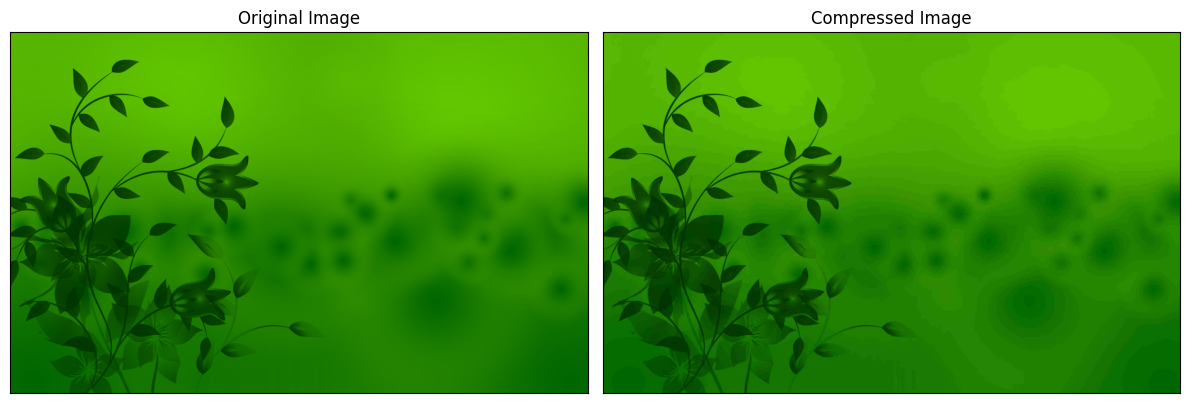

In [10]:
comp = compression_pipeline('Input/green.png')